In [26]:
# import packages
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import scipy.io
import scipy.optimize as op
import pandas as pd
import sys
sys.path.insert(0,"C:/Users/Janine/.local/share/emcee-master")
import emcee as mc
import corner
import warnings

from trig_fund import *
from dambreak import dambreak
from syrup_prop import Visc

# import packages for google drive
import io as IO
import pickle
import os
import os.path
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.http import MediaFileUpload
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2 import service_account

# set default plotting parameters
plt.rc('font', size=22) #set default font size to 22 (from 10)
plt.rcParams['lines.linewidth'] = 2.0 #set default line width to 2.0 (from 1.0)

# filter warnings regularly ecountered in the model
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in power")
warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="invalid value encountered in less")
warnings.filterwarnings("ignore", message="overflow encountered in true_divide")

## Janine Birnbaum 

Created June 28, 2019

Last update July 31, 2019

Read flow data from video files and still images and compare with model.

## Flow of a Herschel-Bulkley fluid on an inclined plane following derivation from Liu & Mei (1989), Balmforth et al. (2007):

$ \frac{\partial h}{\partial t} = -\left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} \left[ \frac{n \left| \sin{\theta} - \cos{\theta} \frac{\partial h}{\partial x} \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} -  \cos{\theta} \frac{\partial h}{\partial x} \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} -\cos{\theta} \frac{\partial h}{\partial x}|} $

For full derivation see included PDF "Viscoplastic Flow Derivation".

## Comparison to experimental data

Import video of experimental data and find the flow front through time:

In [11]:
# import from google drive

SCOPES = ['https://www.googleapis.com/auth/drive']

"""Shows basic usage of the Drive v3 API.
Prints the names and ids of the first 10 files the user has access to.
"""
creds = None
# The file token.pickle stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token_JB.pickle'):
    with open('token_JB.pickle', 'rb') as token:
        creds = pickle.load(token)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'client_secret.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token_JB.pickle', 'wb') as token:
        pickle.dump(creds, token)
        
service = build('drive', 'v3', credentials=creds)

# Call the Drive v3 API
results = service.files().list(q = "name contains 'MVI_0732_edit.avi'", # change just this line to the video filename
    pageSize=5, fields="nextPageToken, files(id, name)").execute()
items = results.get('files', [])

if not items:
    print('No files found.')

fileid = items[0]['id']
filename =  items[0]['name']
filepath = os.getcwd()
request = service.files().get_media(fileId=fileid)
fh = IO.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

print('Saving local copy')
with IO.open(filepath + '/' + filename, 'wb') as f:
    fh.seek(0)
    f.write(fh.read())
print('Done! Loaded ' + filename)

Download 90%.
Download 100%.
Saving local copy
Done! Loaded MVI_0732_edit.avi


In [15]:
# Change these parameters

startFrame = 0
endFrame = 5000

# RGB channel and threshold for front picking
thresh = 85
channel = 1 #0 = Red, 1 = Green, 2 = Blue

# manually set starting location, line for analysis
# black in next figure
x0 = 310 # pixels
yline = 675

# crop image
top = 200
bottom = 1000
left = 300
right = 1800

title_str = 'MVI_0732'
L = 0.2 # reservoir length in m
H = 0.029 # fluid height in reservoir in m
rho = 1.103 # fluid density in kg/m^3
theta = 0 # slope in degrees
T = 19.2 # temperature in deg C
K_fluid = Visc(T) # syrup viscosity in Pas
phi_solid = 0.339 # Particle volume fraction in syrup
phi_gas = 0.197 # Gas volume fraction
particle = 'Plastic' # 'No', 'Plastic', or 'Walnut'

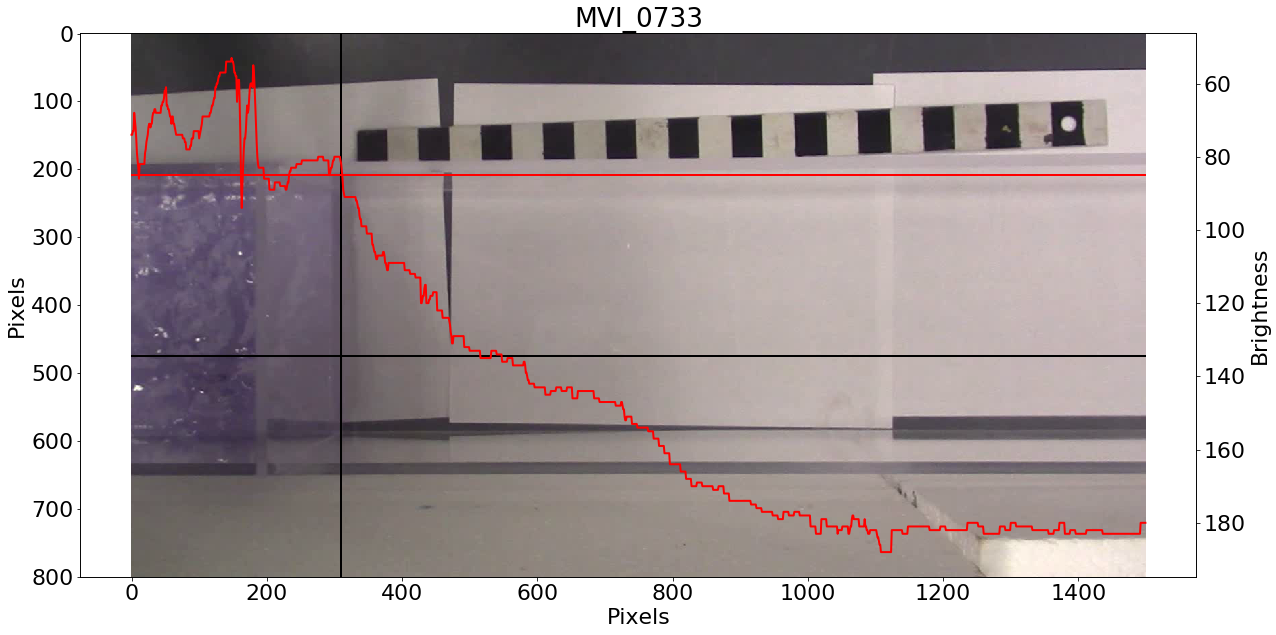

In [14]:
y2 = bottom - top - 1
x2 = right - left - 1

# read first frame from video
cap = cv2.VideoCapture(filename)
fps = cap.get(cv2.CAP_PROP_FPS)

ret, frame = cap.read()
if ret:
    pic = np.flip(frame,2)
    #pic = np.transpose(pic,axes=(1,0,2)) #turn on for flow from top to bottom
cap.release()

# plot cropped image, profile for analysis
# x0 and yline in black
# threshold and profile along yline in red
fig,ax = plt.subplots(figsize=(20,10))
ax.imshow(pic[top:bottom,left:right,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([1, x2], [yline-top, yline-top], 'k')
ax2 = ax.twinx() 
ax2.plot(pic[yline,left:right,channel], 'r')
ax2.plot([1, x2], [thresh, thresh], 'r')
ax2.invert_yaxis()
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax2.set_ylabel('Brightness')
ax.set_title(title_str);

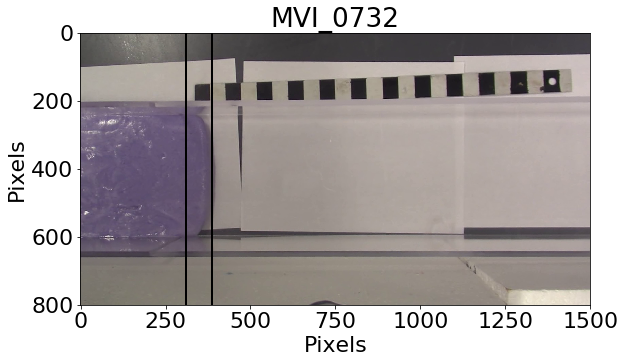

In [16]:
currentFrame = 0

y2 = bottom - top - 1

# read video from start to end frame
cap = cv2.VideoCapture(filename)
fps = cap.get(cv2.CAP_PROP_FPS)
pos = np.zeros(endFrame-startFrame)

while(currentFrame<endFrame):
    ret, frame = cap.read()
    if currentFrame >= startFrame:
        if ret:
            pic = np.flip(frame,2)
            #pic = np.transpose(pic,axes=(1,0,2)) #turn on for flow from top to bottom
            pos[currentFrame - startFrame] = np.max(np.where(pic[yline,left:right,channel]<thresh))
    
    currentFrame += 1
    
cap.release()

# plot final frame
fig,ax = plt.subplots(figsize=(15,5))
ax.imshow(pic[top:bottom,left:right,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([pos[-1], pos[-1]], [0, y2], 'k')
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title(title_str);

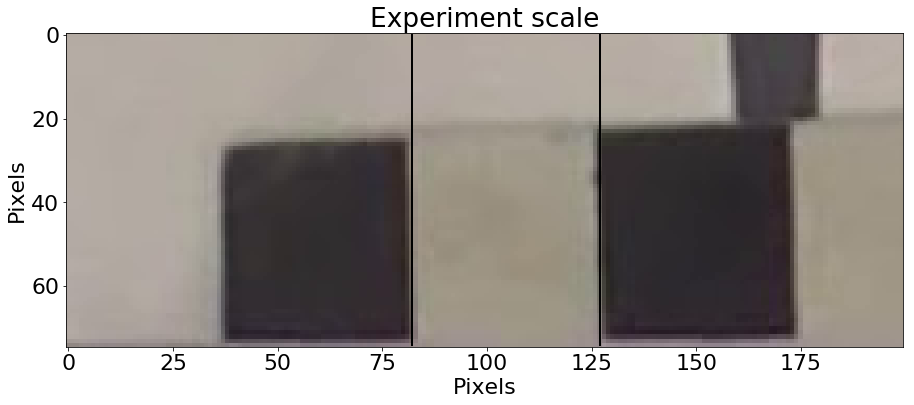

In [17]:
# Calculate image scale
# Crop image
top2 = 325
bottom2 = 400
left2 = 600
right2 = 800

# Plot
fig,ax = plt.subplots(figsize=(15,20))
ax.imshow(pic[top2:bottom2,left2:right2,:])

# Set to align with one 2cm segment on scale
lft = 82
rgt = 127

# Plot
ax.plot([lft, lft], [0, bottom2-top2-1], 'k')
ax.plot([rgt, rgt], [0, bottom2-top2-1], 'k')

# Determine scaling factors
W = 0.02 # m
k = W/(rgt-lft) # m/pixel
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title('Experiment scale');

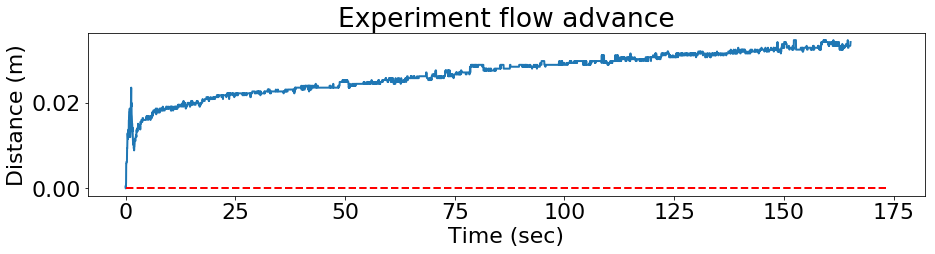

In [18]:
# scale time and front position
pos_scaled = (pos-x0)*k
pos_scaled[pos_scaled<0] = 0
t_scaled = np.arange((pos_scaled).size)/fps

t0 = 1.6 # Time of dam release [sec]
tf = 175 # End time [sec]

pos_scaled = pos_scaled[(t_scaled>t0) & (t_scaled<tf)]
t_scaled = t_scaled[(t_scaled>t0) & (t_scaled<tf)]-t0

# plot scaled front advance
fig,ax = plt.subplots(figsize=(15,3))
ax.plot(t_scaled, pos_scaled)
ax.plot([0, tf - t0], [0, 0], 'r--')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Distance (m)')
ax.set_title('Experiment flow advance');

In [90]:
# Save data to file

df = pd.DataFrame({'X_pos':pos_scaled, 'Time':t_scaled})
meta = pd.DataFrame({'H':H, 'L':L, 'K_fluid':K_fluid, 'Rho':rho, 'Slope':theta, 'Title':title_str, 'Temp':T,
                    'Phi_solid':phi_solid, 'Phi_gas':phi_gas, 'Particle':particle}, index=[0])

df.to_hdf(title_str + '.h5', key='df', mode='w')
meta.to_hdf(title_str + '.h5', key='meta', mode='a')

file_metadata = {'name': title_str + '.h5', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
media = MediaFileUpload(title_str + '.h5')
file = service.files().create(body=file_metadata,
                                    media_body=media).execute()

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [19]:
# Setup model for MCMC

def lnlike(mu, x, y, yerr):
    K, tauy, n = mu
    h, t = dambreak(x_grid, h0, 0, 1540, K, tauy, n, 9.81, t_scaled[-1], 25*t_scaled.shape[0])
    X = np.zeros_like(t_scaled)

    threshold = 0.0001
    for j in np.arange(t_scaled.shape[0]):
        X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold
    ind = np.nonzero(X[1:] - X[:-1])[0]
    model = np.interp(t_match,t_match[ind],X[ind])

    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*yerr**2)))

In [20]:
# Initial guesses for MCMC
K_init = 19.7
K_min = 15
K_max = 25

tauy_init = 0.01
tauy_min = 0
tauy_max = 0.5

n_init = 0.94
n_min = 0.8
n_max = 3

init_pos = [K_init, tauy_init, n_init]

# load data to MCMC
x = t_scaled
y = pos_scaled + L

# Define model resolution for MCMC
x_grid = np.linspace(0,0.75,52)
dx = x[1] - x[0]
yerr = 2*dx
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H

In [21]:
# Uniform prior distribution
def lnprior(mu):
    K, tauy, n = mu
    if K_min < K < K_max and tauy_min < tauy < tauy_max and n_min < n < n_max:
        return 0.0
    return -np.inf

def lnprob(mu, x, y, yerr):
    lp = lnprior(mu)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(mu, x, y, yerr)

In [22]:
# Create walkers
ndim, nwalkers = 3, 6
mu_pos = [init_pos + [1e-1, 1e-2, 1e-2]*np.random.randn(ndim) for i in range(nwalkers)]

In [23]:
# Run MCMC
steps = 10
sampler = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(mu_pos, steps, progress=True);

C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Janine\Anaconda3\envs\three-phase-flow\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


K = 19.7, tau_y = 0.02, n = 0.94


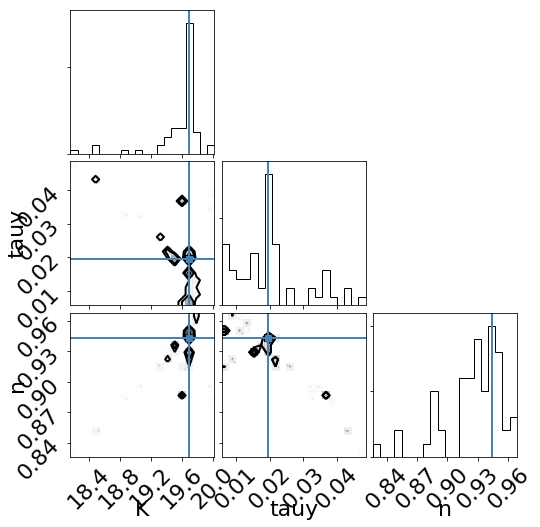

In [24]:
# Inspect MCMC results
s = 0 # ignore initial samples
samples = sampler.chain[:, s:, :].reshape((-1, ndim))

K_fit = samples[:,0]; tauy_fit = samples[:,1]; n_fit = samples[:,2]

# Find mode of each posterior distribution
N, bin_edges = np.histogram(K_fit, bins=20)
K_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(tauy_fit, bins=20)
tauy_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(n_fit, bins=20)
n_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 

# Find standard deviation
K_std = np.std(K_fit)
tauy_std = np.std(tauy_fit)
n_std = np.std(n_fit)

# plot
fig = corner.corner(samples, labels=["K", "tauy", "n"],
                   truths=[K_post, tauy_post, n_post])
print('K = ' + np.array2string(K_post, precision=1) + ' +- ' + np.array2string(2*K_std, precision=1) +
      ', tau_y = ' + np.array2string(tauy_post, precision=2) + ' +- ' + np.array2string(2*tauy_std, precision=2) +
      ', n = ' + np.array2string(n_post, precision=2) + ' +- ' + np.array2string(2*n_std, precision=2))

In [ ]:
# inspect runs
fig,ax = plt.subplots(nrows=3, figsize=(15,15))
ax[0].plot(samples[:,0],'b-')
ax[0].plot([0, samples.shape[0]],[K_post, K_post],'r--')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('K')
ax[1].plot(samples[:,1],'b-')
ax[1].plot([0, samples.shape[0]],[tauy_post, tauy_post],'r--')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('tauy')
ax[2].plot(samples[:,2],'b-')
ax[2].plot([0, samples.shape[0]],[n_post, n_post],'r--')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('n');

In [ ]:
h, t = dambreak(x_grid, h0, 0, 1540, 10, 0.01, 1, 9.81, np.max(t_scaled), 25*t_scaled.shape[0])
X = np.zeros_like(t_scaled)
t_match = np.zeros_like(t_scaled)

threshold = 0.0001
for j in np.arange(t_scaled.shape[0]):
    X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold
    t_match[j] = t[j*25]

# Plot front advance
fig,ax = plt.subplots(figsize=(20,10))

ax.plot(t_match,X,'r-',label='model');
ax.plot(t_scaled,pos_scaled+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

In [ ]:
# Save posterior distribution

meta['K_post'] = K_post
meta['tauy_post'] = tauy_post
meta['n_post'] = n_post
meta['K_std'] = K_std
meta['tauy_std'] = tauy_std
meta['n_std'] = n_std

meta.to_hdf(title_str + '.h5', key='meta', mode='a')

samples = pd.DataFrame({'K':K_fit, 'tauy':tauy_fit, 'n':n_fit})
samples.to_hdf(title_str + '.h5', key='s', mode='a')

file_metadata = {'name': title_str + '.h5', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
media = MediaFileUpload(title_str + '.h5')
file = service.files().create(body=file_metadata,
                                    media_body=media).execute()

In [91]:
# remove local files after upload
media = None

os.remove(filename)
os.remove(title_str + '.h5')